## ***Packages***

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import datetime
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
import itertools


## ***2.1: Feature Engineering***

In [2]:
# Caricamento dei dataset
genome_scores = pd.read_csv('/Users/lucaderuggiero/Desktop/dataset ADM3/genome_scores.csv')
genome_tags = pd.read_csv('/Users/lucaderuggiero/Desktop/dataset ADM3/genome_tags.csv')
links = pd.read_csv('/Users/lucaderuggiero/Desktop/dataset ADM3/link.csv')
movies = pd.read_csv('/Users/lucaderuggiero/Desktop/dataset ADM3/movie.csv')
ratings = pd.read_csv('/Users/lucaderuggiero/Desktop/dataset ADM3/rating.csv')
tags = pd.read_csv('/Users/lucaderuggiero/Desktop/dataset ADM3/tag.csv')

# Visualizzazione delle prime righe di ogni dataset
print("Genome Scores:")
print(genome_scores.head())
print("\nGenome Tags:")
print(genome_tags.head())
print("\nLinks:")
print(links.head())
print("\nMovies:")
print(movies.head())
print("\nRatings:")
print(ratings.head())
print("\nTags:")
print(tags.head())


Genome Scores:
   movieId  tagId  relevance
0        1      1    0.02500
1        1      2    0.02500
2        1      3    0.05775
3        1      4    0.09675
4        1      5    0.14675

Genome Tags:
   tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s

Links:
   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

Movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                         

In [3]:
datasets = {
    "genome_scores": genome_scores,
    "genome_tags": genome_tags,
    "links": links,
    "movies": movies,
    "ratings": ratings,
    "tags": tags
}



for name, df in datasets.items():
    print(f"Dataset: {name}")
    print(f" - Dimensioni: {df.shape}")
    print(f" - Valori nulli:\n{df.isnull().sum()}")
    print(f" - Duplicati: {df.duplicated().sum()}\n")


Dataset: genome_scores
 - Dimensioni: (11709768, 3)
 - Valori nulli:
movieId      0
tagId        0
relevance    0
dtype: int64
 - Duplicati: 0

Dataset: genome_tags
 - Dimensioni: (1128, 2)
 - Valori nulli:
tagId    0
tag      0
dtype: int64
 - Duplicati: 0

Dataset: links
 - Dimensioni: (27278, 3)
 - Valori nulli:
movieId      0
imdbId       0
tmdbId     252
dtype: int64
 - Duplicati: 0

Dataset: movies
 - Dimensioni: (27278, 3)
 - Valori nulli:
movieId    0
title      0
genres     0
dtype: int64
 - Duplicati: 0

Dataset: ratings
 - Dimensioni: (20000263, 4)
 - Valori nulli:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
 - Duplicati: 0

Dataset: tags
 - Dimensioni: (465564, 4)
 - Valori nulli:
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64
 - Duplicati: 0



**Let's create "ratings_avg" as a new feature for the dataset**

In [4]:
# Calcolo della media dei voti per ogni film
ratings_avg = ratings.groupby('movieId')['rating'].mean().reset_index()
ratings_avg.rename(columns={'rating': 'ratings_avg'}, inplace=True)

# Unione con il dataset dei film
movies_with_ratings = pd.merge(movies, ratings_avg, on='movieId', how='left')

print("Movies con Media Ratings:")
print(movies_with_ratings.head())

Movies con Media Ratings:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  ratings_avg  
0  Adventure|Animation|Children|Comedy|Fantasy     3.921240  
1                   Adventure|Children|Fantasy     3.211977  
2                               Comedy|Romance     3.151040  
3                         Comedy|Drama|Romance     2.861393  
4                                       Comedy     3.064592  


**Let's do the one-hot encoding for each genres of the dataset**

In [5]:
# Separazione dei generi in colonne binarie (one-hot encoding)
genres_onehot = movies_with_ratings['genres'].str.get_dummies(sep='|')

# Unione delle colonne binarie al DataFrame principale
movies_with_features = pd.concat([movies_with_ratings, genres_onehot], axis=1)

# Rimozione della colonna "genres" originale
movies_with_features.drop('genres', axis=1, inplace=True)

print("Movies con One-Hot Encoding dei Generi:")
print(movies_with_features.head())

Movies con One-Hot Encoding dei Generi:
   movieId                               title  ratings_avg  \
0        1                    Toy Story (1995)     3.921240   
1        2                      Jumanji (1995)     3.211977   
2        3             Grumpier Old Men (1995)     3.151040   
3        4            Waiting to Exhale (1995)     2.861393   
4        5  Father of the Bride Part II (1995)     3.064592   

   (no genres listed)  Action  Adventure  Animation  Children  Comedy  Crime  \
0                   0       0          1          1         1       1      0   
1                   0       0          1          0         1       0      0   
2                   0       0          0          0         0       1      0   
3                   0       0          0          0         0       1      0   
4                   0       0          0          0         0       1      0   

   ...  Film-Noir  Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  \
0  ...          0   

**Calculate the global_avg_rating for the ratings_avg and replace NaN with it**

In [6]:
# Calcola la media generale
global_avg_rating = movies_with_features['ratings_avg'].mean()

# Sostituisci NaN con la media generale
movies_with_features['ratings_avg'] = movies_with_features['ratings_avg'].fillna(global_avg_rating)

**Let's create "relevant_genome_tag". NaN values will have "Tag Not Relevant"**

In [7]:
# Troviamo il tag con la rilevanza massima per ogni movieId
relevant_tag = genome_scores.loc[genome_scores.groupby('movieId')['relevance'].idxmax()]

# Uniamo per ottenere il nome del tag più rilevante
relevant_tag = pd.merge(relevant_tag, genome_tags, on='tagId', how='left')

# Manteniamo solo movieId e il nome del tag più rilevante
relevant_tag = relevant_tag[['movieId', 'tag']].rename(columns={'tag': 'relevant_genome_tag'})

# Aggiungiamo al dataset principale
movies_with_features = pd.merge(movies_with_features, relevant_tag, on='movieId', how='left')

# sostituire i valori nulli con la stringa 'Tag Not Relevant'
movies_with_features['relevant_genome_tag'] = movies_with_features['relevant_genome_tag'].fillna('Tag Not Relevant')


**Let's create "common_user_tag". NaN values will have "No Tags"**

In [8]:
# Troviamo il tag più frequente per ogni movieId
common_tag = tags.groupby(['movieId', 'tag']).size().reset_index(name='count')
common_tag = common_tag.loc[common_tag.groupby('movieId')['count'].idxmax()]

# Manteniamo solo movieId e il tag più comune
common_tag = common_tag[['movieId', 'tag']].rename(columns={'tag': 'common_user_tag'})

# Aggiungiamo al dataset principale
movies_with_features = pd.merge(movies_with_features, common_tag, on='movieId', how='left')

movies_with_features['common_user_tag'] = movies_with_features['common_user_tag'].fillna('No Tags')

print("Movies con Common User Tag:")
print(movies_with_features[['movieId', 'title', 'common_user_tag']].head())

Movies con Common User Tag:
   movieId                               title common_user_tag
0        1                    Toy Story (1995)           Pixar
1        2                      Jumanji (1995)  Robin Williams
2        3             Grumpier Old Men (1995)           moldy
3        4            Waiting to Exhale (1995)      characters
4        5  Father of the Bride Part II (1995)    steve martin


**Let's create "ratings_count"**

In [9]:
# Calcolo del numero totale di voti per ogni film
ratings_count = ratings.groupby('movieId')['rating'].count().reset_index()
ratings_count.rename(columns={'rating': 'ratings_count'}, inplace=True)

# Unione con il dataset principale
movies_with_features = pd.merge(movies_with_features, ratings_count, on='movieId', how='left')

# Riempire eventuali valori nulli con 0 (per film senza voti)
movies_with_features['ratings_count'] = movies_with_features['ratings_count'].fillna(0)

print("Movies con Ratings Count aggiunto:")
print(movies_with_features[['movieId', 'title', 'ratings_count']].head())

Movies con Ratings Count aggiunto:
   movieId                               title  ratings_count
0        1                    Toy Story (1995)        49695.0
1        2                      Jumanji (1995)        22243.0
2        3             Grumpier Old Men (1995)        12735.0
3        4            Waiting to Exhale (1995)         2756.0
4        5  Father of the Bride Part II (1995)        12161.0


**Let's create "release_year"**

In [10]:
# Estrazione dell'anno dal titolo
movies_with_features['release_year'] = movies_with_features['title'].str.extract(r'\((\d{4})\)', expand=False)
movies_with_features['release_year'] = pd.to_numeric(movies_with_features['release_year'], errors='coerce')

# Convertire in intero
# Riempire i valori NaN con 0 (o un valore specifico, come 1900, se preferisci)
movies_with_features['release_year'] = movies_with_features['release_year'].fillna(0)

movies_with_features['release_year'] = movies_with_features['release_year'].astype(int)

print("Movies con Release Year come intero:")
print(movies_with_features[['movieId', 'title', 'release_year']].head())

Movies con Release Year come intero:
   movieId                               title  release_year
0        1                    Toy Story (1995)          1995
1        2                      Jumanji (1995)          1995
2        3             Grumpier Old Men (1995)          1995
3        4            Waiting to Exhale (1995)          1995
4        5  Father of the Bride Part II (1995)          1995


**Let's create "genre_count"**

In [11]:
# creo genre_count
movies_with_features['genre_count'] = movies_with_features[genres_onehot.columns].sum(axis=1)


**Let's create "years_since_release"**

In [13]:
# Calcola l'anno corrente
current_year = datetime.now().year

# Differenza tra l'anno corrente e l'anno di uscita
movies_with_features['years_since_release'] = current_year - movies_with_features['release_year']

# Gestisci eventuali anni fittizi come 0 o 1900
movies_with_features.loc[movies_with_features['release_year'] <= 0, 'years_since_release'] = None


# convertire in intero
# Riempire i valori NaN con 0 
movies_with_features['years_since_release'] = movies_with_features['years_since_release'].fillna(0)
movies_with_features['years_since_release'] = movies_with_features['years_since_release'].astype(int)

print("Movies con Time Since Release aggiunto:")
print(movies_with_features[['movieId', 'title', 'years_since_release']].head())

Movies con Time Since Release aggiunto:
   movieId                               title  years_since_release
0        1                    Toy Story (1995)                   29
1        2                      Jumanji (1995)                   29
2        3             Grumpier Old Men (1995)                   29
3        4            Waiting to Exhale (1995)                   29
4        5  Father of the Bride Part II (1995)                   29


In [14]:
movies_with_features

,movieId,title,ratings_avg,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Sci-Fi,Thriller,War,Western,relevant_genome_tag,common_user_tag,ratings_count,release_year,genre_count,years_since_release
0,1,Toy Story (1995),3.921240,0,0,1,1,1,1,0,...,0,0,0,0,toys,Pixar,49695.0,1995,5,29
1,2,Jumanji (1995),3.211977,0,0,1,0,1,0,0,...,0,0,0,0,adventure,Robin Williams,22243.0,1995,3,29
2,3,Grumpier Old Men (1995),3.151040,0,0,0,0,0,1,0,...,0,0,0,0,good sequel,moldy,12735.0,1995,2,29
3,4,Waiting to Exhale (1995),2.861393,0,0,0,0,0,1,0,...,0,0,0,0,women,characters,2756.0,1995,3,29
4,5,Father of the Bride Part II (1995),3.064592,0,0,0,0,0,1,0,...,0,0,0,0,good sequel,steve martin,12161.0,1995,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),4.000000,0,0,0,0,0,1,0,...,0,0,0,0,Tag Not Relevant,No Tags,1.0,2007,1,17
27274,131256,"Feuer, Eis & Dosenbier (2002)",4.000000,0,0,0,0,0,1,0,...,0,0,0,0,Tag Not Relevant,No Tags,1.0,2002,1,22
27275,131258,The Pirates (2014),2.500000,0,0,1,0,0,0,0,...,0,0,0,0,Tag Not Relevant,Korea,1.0,2014,1,10
27276,131260,Rentun Ruusu (2001),3.000000,1,0,0,0,0,0,0,...,0,0,0,0,Tag Not Relevant,No Tags,1.0,2001,1,23


In [15]:
# creo un file csv per movies_with_features
movies_with_features.to_csv('/Users/lucaderuggiero/Desktop/dataset ADM3/movies_with_features.csv', index=False)

***Note: If you have accurately identified and applied the methods for representing the features, you should have more than eight features! How could this happen? Take a moment to think about it.***

We have more than eight features.
That's possible thanks to:
- the one-hot encoding for the genres of the movies. In fact, from having a single column, now we have a column for each genre;
- the creation of the new features (like "ratings_count" or "years_since_release") which gives new info about the data.

***Now, we're going to:***

***- create a copy of "movies_with_features" for simplicity called "movies"***

***- add "relevant_genome_tag_count" and "common_user_tag_count" to the dataset "movies" and standardize those new features***

***- continue with our analysis of PCA and clustering***

In [74]:
movies = movies_with_features.copy()

In [83]:
# Calcolare i conteggi di ciascun valore unico
tag_counts = movies['relevant_genome_tag'].value_counts()

# Sostituire i valori nella colonna con i loro conteggi
movies['relevant_genome_tag_count'] = movies['relevant_genome_tag'].map(tag_counts)

# Visualizzare i risultati
print(movies[['relevant_genome_tag', 'relevant_genome_tag_count']].head())


  relevant_genome_tag  relevant_genome_tag_count
0                toys                          5
1           adventure                         24
2         good sequel                         19
3               women                         38
4         good sequel                         19


In [85]:
# common_user_tag_count
tag_counts = movies['common_user_tag'].value_counts()

# Sostituire i valori nella colonna con i loro conteggi
movies['common_user_tag_count'] = movies['common_user_tag'].map(tag_counts)

# Visualizzare i risultati
print(movies[['common_user_tag', 'common_user_tag_count']].head())

  common_user_tag  common_user_tag_count
0           Pixar                     27
1  Robin Williams                     16
2           moldy                      1
3      characters                      3
4    steve martin                      1


In [87]:
# Standardizzazione delle feature numeriche
scaler = StandardScaler()

# Selezionare solo le colonne numeriche
numerical_cols = ['ratings_avg', 'ratings_count', 'release_year', 'genre_count', 'years_since_release', 'relevant_genome_tag_count', 'common_user_tag_count']

# Standardizzazione
movies[numerical_cols] = scaler.fit_transform(movies[numerical_cols])




In [88]:
movies

,movieId,title,ratings_avg,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,War,Western,relevant_genome_tag,common_user_tag,ratings_count,release_year,genre_count,years_since_release,relevant_genome_tag_count,common_user_tag_count
0,1,Toy Story (1995),1.198467,0,0,1,1,1,1,0,...,0,0,toys,Pixar,16.015433,0.118376,2.894060,-0.239887,-1.281111,-0.650275
1,2,Jumanji (1995),0.119805,0,0,1,0,1,0,0,...,0,0,adventure,Robin Williams,7.035868,0.118376,0.968217,-0.239887,-1.278789,-0.653467
2,3,Grumpier Old Men (1995),0.027132,0,0,0,0,0,1,0,...,0,0,good sequel,moldy,3.925795,0.118376,0.005295,-0.239887,-1.279400,-0.657820
3,4,Waiting to Exhale (1995),-0.413369,0,0,0,0,0,1,0,...,0,0,women,characters,0.661659,0.118376,0.968217,-0.239887,-1.277077,-0.657239
4,5,Father of the Bride Part II (1995),-0.104341,0,0,0,0,0,1,0,...,0,0,good sequel,steve martin,3.738040,0.118376,-0.957627,-0.239887,-1.279400,-0.657820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),1.318247,0,0,0,0,0,1,0,...,0,0,Tag Not Relevant,No Tags,-0.239503,0.314771,-0.957627,-0.753883,0.783809,1.585721
27274,131256,"Feuer, Eis & Dosenbier (2002)",1.318247,0,0,0,0,0,1,0,...,0,0,Tag Not Relevant,No Tags,-0.239503,0.232940,-0.957627,-0.539718,0.783809,1.585721
27275,131258,The Pirates (2014),-0.962984,0,0,1,0,0,0,0,...,0,0,Tag Not Relevant,Korea,-0.239503,0.429335,-0.957627,-1.053714,0.783809,-0.657529
27276,131260,Rentun Ruusu (2001),-0.202573,1,0,0,0,0,0,0,...,0,0,Tag Not Relevant,No Tags,-0.239503,0.216573,-0.957627,-0.496885,0.783809,1.585721


## ***From this point now we'll divide our analysis in three different parts:***

***- In the first part we're going to 

# ***A) TEST with Tag Counts --> Standardize and doing PCA with these features***

### ***PCA 1) Let's try with movies_1a --> numerical fetures + genres***

In [89]:
movies_1 = movies.copy()

In [91]:
movies_1a = movies_1.drop(['movieId', 'title', 'relevant_genome_tag', 'common_user_tag'], axis=1)

In [242]:
movies_1a

,ratings_avg,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Sci-Fi,Thriller,War,Western,ratings_count,release_year,genre_count,years_since_release,relevant_genome_tag_count,common_user_tag_count
0,1.198467,0,0,1,1,1,1,0,0,0,...,0,0,0,0,16.015433,0.118376,2.894060,-0.239887,-1.281111,-0.650275
1,0.119805,0,0,1,0,1,0,0,0,0,...,0,0,0,0,7.035868,0.118376,0.968217,-0.239887,-1.278789,-0.653467
2,0.027132,0,0,0,0,0,1,0,0,0,...,0,0,0,0,3.925795,0.118376,0.005295,-0.239887,-1.279400,-0.657820
3,-0.413369,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0.661659,0.118376,0.968217,-0.239887,-1.277077,-0.657239
4,-0.104341,0,0,0,0,0,1,0,0,0,...,0,0,0,0,3.738040,0.118376,-0.957627,-0.239887,-1.279400,-0.657820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,1.318247,0,0,0,0,0,1,0,0,0,...,0,0,0,0,-0.239503,0.314771,-0.957627,-0.753883,0.783809,1.585721
27274,1.318247,0,0,0,0,0,1,0,0,0,...,0,0,0,0,-0.239503,0.232940,-0.957627,-0.539718,0.783809,1.585721
27275,-0.962984,0,0,1,0,0,0,0,0,0,...,0,0,0,0,-0.239503,0.429335,-0.957627,-1.053714,0.783809,-0.657529
27276,-0.202573,1,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.239503,0.216573,-0.957627,-0.496885,0.783809,1.585721


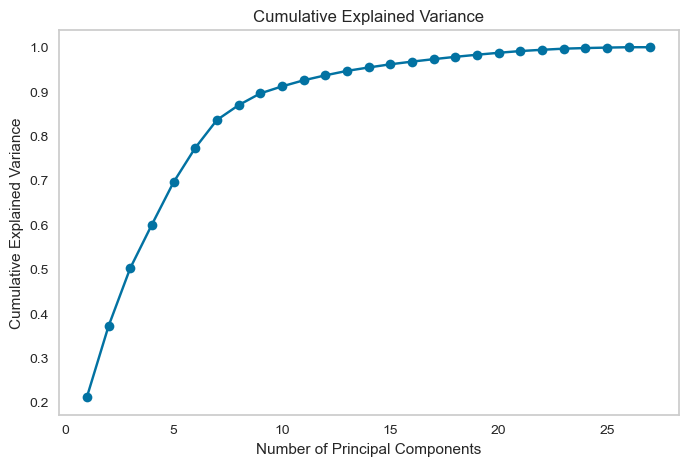

Componente 1: 21.10% varianza spiegata
Componente 2: 16.01% varianza spiegata
Componente 3: 13.06% varianza spiegata
Componente 4: 9.83% varianza spiegata
Componente 5: 9.56% varianza spiegata
Componente 6: 7.74% varianza spiegata
Componente 7: 6.29% varianza spiegata
Componente 8: 3.34% varianza spiegata
Componente 9: 2.65% varianza spiegata
Componente 10: 1.58% varianza spiegata
Componente 11: 1.38% varianza spiegata
Componente 12: 1.12% varianza spiegata
Componente 13: 1.00% varianza spiegata
Componente 14: 0.77% varianza spiegata
Componente 15: 0.71% varianza spiegata
Componente 16: 0.60% varianza spiegata
Componente 17: 0.56% varianza spiegata
Componente 18: 0.52% varianza spiegata
Componente 19: 0.47% varianza spiegata
Componente 20: 0.44% varianza spiegata
Componente 21: 0.39% varianza spiegata
Componente 22: 0.28% varianza spiegata
Componente 23: 0.25% varianza spiegata
Componente 24: 0.14% varianza spiegata
Componente 25: 0.10% varianza spiegata
Componente 26: 0.08% varianza s

In [98]:
# Applicare la PCA con i generi
pca = PCA()
pca_components1 = pca.fit_transform(movies_1a)

# Visualizzare la varianza spiegata da ciascuna componente principale
explained_variance1 = pca.explained_variance_ratio_

# Scree Plot per analizzare la varianza spiegata
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance1) + 1), explained_variance1.cumsum(), marker='o')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

# Output della varianza spiegata per ciascuna componente
for i, variance in enumerate(explained_variance1, 1):
    print(f"Componente {i}: {variance:.2%} varianza spiegata")

In [99]:
# Scegliere il numero di componenti principali (ad esempio, quelle che spiegano il 90% della varianza)
cumulative_variance1 = np.cumsum(explained_variance1)
n_components = np.argmax(cumulative_variance1 >= 0.80) + 1  # Numero minimo di componenti per spiegare il 90%
print(f"Numero di componenti principali necessarie per spiegare l'80% della varianza: {n_components}")

Numero di componenti principali necessarie per spiegare l'80% della varianza: 7


### ***PCA 2) Let's try with movies_1b --> numerical features only (without genres)***

In [94]:
movies_1b = movies_1.drop(['movieId', 'title', 'relevant_genome_tag', 'common_user_tag', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], axis=1)


In [241]:
movies_1b

,ratings_avg,(no genres listed),ratings_count,release_year,genre_count,years_since_release,relevant_genome_tag_count,common_user_tag_count
0,1.198467,0,16.015433,0.118376,2.894060,-0.239887,-1.281111,-0.650275
1,0.119805,0,7.035868,0.118376,0.968217,-0.239887,-1.278789,-0.653467
2,0.027132,0,3.925795,0.118376,0.005295,-0.239887,-1.279400,-0.657820
3,-0.413369,0,0.661659,0.118376,0.968217,-0.239887,-1.277077,-0.657239
4,-0.104341,0,3.738040,0.118376,-0.957627,-0.239887,-1.279400,-0.657820
...,...,...,...,...,...,...,...,...
27273,1.318247,0,-0.239503,0.314771,-0.957627,-0.753883,0.783809,1.585721
27274,1.318247,0,-0.239503,0.232940,-0.957627,-0.539718,0.783809,1.585721
27275,-0.962984,0,-0.239503,0.429335,-0.957627,-1.053714,0.783809,-0.657529
27276,-0.202573,1,-0.239503,0.216573,-0.957627,-0.496885,0.783809,1.585721


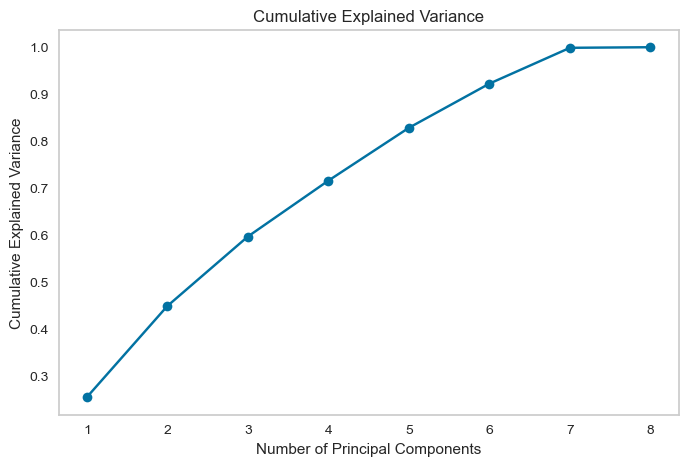

Componente 1: 25.50% varianza spiegata
Componente 2: 19.41% varianza spiegata
Componente 3: 14.79% varianza spiegata
Componente 4: 11.90% varianza spiegata
Componente 5: 11.25% varianza spiegata
Componente 6: 9.40% varianza spiegata
Componente 7: 7.62% varianza spiegata
Componente 8: 0.12% varianza spiegata


In [100]:
# Applicare la PCA con i generi
pca = PCA()
pca_components2 = pca.fit_transform(movies_1b)

# Visualizzare la varianza spiegata da ciascuna componente principale
explained_variance2 = pca.explained_variance_ratio_

# Scree Plot per analizzare la varianza spiegata
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance2) + 1), explained_variance2.cumsum(), marker='o')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

# Output della varianza spiegata per ciascuna componente
for i, variance in enumerate(explained_variance2, 1):
    print(f"Componente {i}: {variance:.2%} varianza spiegata")

In [101]:
# Scegliere il numero di componenti principali (ad esempio, quelle che spiegano il 90% della varianza)
cumulative_variance2 = np.cumsum(explained_variance2)
n_components = np.argmax(cumulative_variance2 >= 0.80) + 1  # Numero minimo di componenti per spiegare il 90%
print(f"Numero di componenti principali necessarie per spiegare l'80% della varianza: {n_components}")

Numero di componenti principali necessarie per spiegare l'80% della varianza: 5


## ***Clustering: with "movies_1a" and then with "movies_1b"***

### ***CLS 1) Let's try it with movies_1a (with genres)***

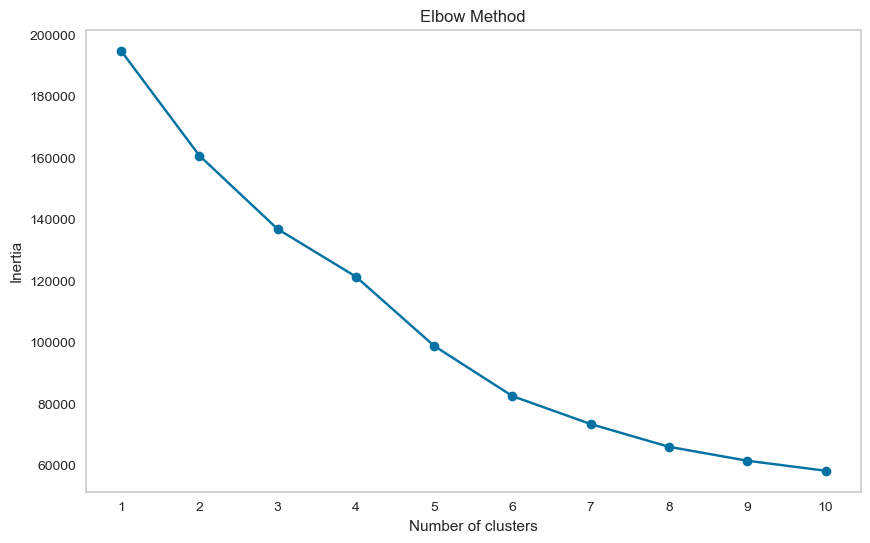

In [147]:
# 1. Elbow Method 
inertia = []
k_values = range(1, 11)

X_pca1 = pca_components1[:, :7]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca1)
    inertia.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

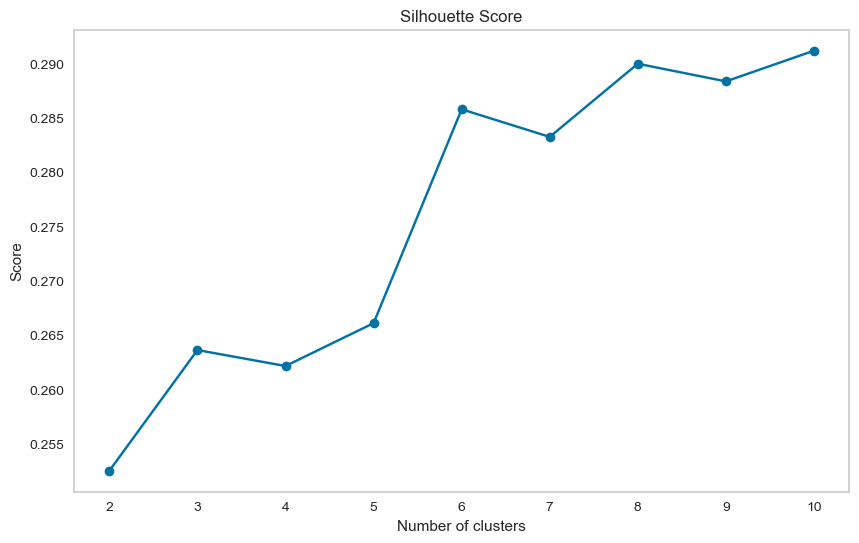

In [148]:
# 2. Silhouette Score

silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels1 = kmeans.fit_predict(X_pca1)
    score1 = silhouette_score(X_pca1, labels1)
    silhouette_scores.append(score1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='b')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.xticks(k_values)
plt.grid()
plt.show()

In [149]:
def map_phase(data, centroids):
    # Per ogni punto, calcola la distanza da ciascun centroide e assegna un cluster
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    cluster_assignments = np.argmin(distances, axis=1)
    return cluster_assignments


def reduce_phase(data, cluster_assignments, k):
    # Per ogni cluster, calcola la media dei punti assegnati
    new_centroids = np.array([
        data[cluster_assignments == i].mean(axis=0) for i in range(k)
    ])
    return new_centroids


def k_means_mapreduce(data, k, max_iters=100, tol=1e-4):
    # Inizializza i centroidi in modo casuale
    np.random.seed(42)
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    for i in range(max_iters):
        # Fase Map: assegnare ogni punto al cluster più vicino
        cluster_assignments = map_phase(data, centroids)

        # Fase Reduce: calcolare i nuovi centroidi
        new_centroids = reduce_phase(data, cluster_assignments, k)

        # Controllare la convergenza
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, cluster_assignments


In [154]:
# Clustering sul primo dataset (con generi)
centroids_case1, labels_case1 = k_means_mapreduce(X_pca1, k=5)


In [155]:
unique1, counts1 = np.unique(labels_case1, return_counts=True)
for cluster_id, count in zip(unique1, counts1):
    print(f"Cluster {cluster_id}: {count} punti")


Cluster 0: 6554 punti
Cluster 1: 3791 punti
Cluster 2: 6708 punti
Cluster 3: 5712 punti
Cluster 4: 4513 punti


In [157]:
cluster_means1 = np.array([X_pca1[labels_case1 == i].mean(axis=0) for i in range(5)])

for i, mean in enumerate(cluster_means1):
    print(f"Cluster {i}: {mean}")


Cluster 0: [ 0.21233631 -0.42068662 -0.4844627  -0.39089642  0.15961484 -0.08943559
  0.92535883]
Cluster 1: [-2.01350766 -0.2310252   1.00176835  0.06437375  0.12169965 -0.15610911
 -0.13963553]
Cluster 2: [ 1.4432545  -0.5722919   0.32909539  0.62755805  0.36833213 -0.20910599
 -0.48305727]
Cluster 3: [-1.00994764 -0.13092043 -0.67748353 -0.14209483 -0.76504752 -0.0747491
 -0.49676655]
Cluster 4: [ 0.51607026  1.82134904  0.23037419 -0.23933515  0.08679382  0.66643483
  0.12019393]


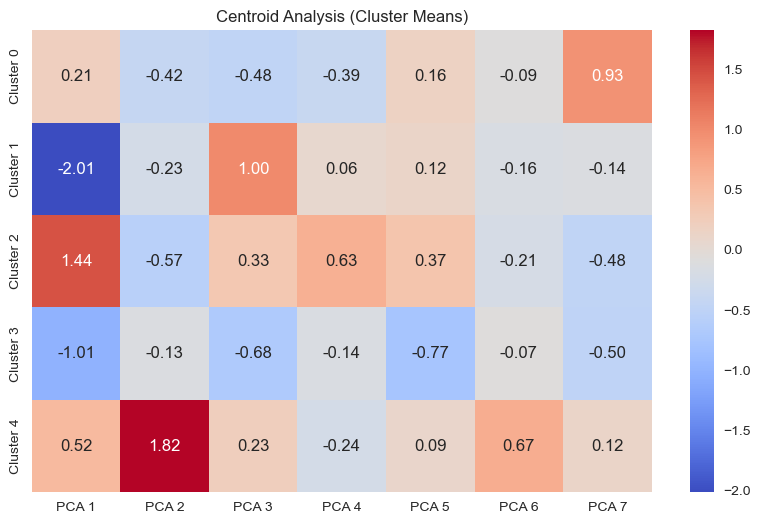

In [158]:
# Creare un DataFrame per i centroidi
centroid_df1 = pd.DataFrame({
    'Cluster 0': [0.21233631, -0.42068662, -0.4844627, -0.39089642, 0.15961484, -0.08943559, 0.92535883],
    'Cluster 1': [-2.01350766, -0.2310252, 1.00176835, 0.06437375, 0.12169965, -0.15610911, -0.13963553],
    'Cluster 2': [1.4432545, -0.5722919, 0.32909539, 0.62755805, 0.36833213, -0.20910599, -0.48305727],
    'Cluster 3': [-1.00994764, -0.13092043, -0.67748353, -0.14209483, -0.76504752, -0.0747491, -0.49676655],
    'Cluster 4': [0.51607026, 1.82134904, 0.23037419, -0.23933515, 0.08679382, 0.66643483, 0.12019393]
}).T

centroid_df1.columns = [f"PCA {i+1}" for i in range(centroid_df1.shape[1])]

# Heatmap dei centroidi
plt.figure(figsize=(10, 6))
sns.heatmap(centroid_df1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Centroid Analysis (Cluster Means)")
plt.show()


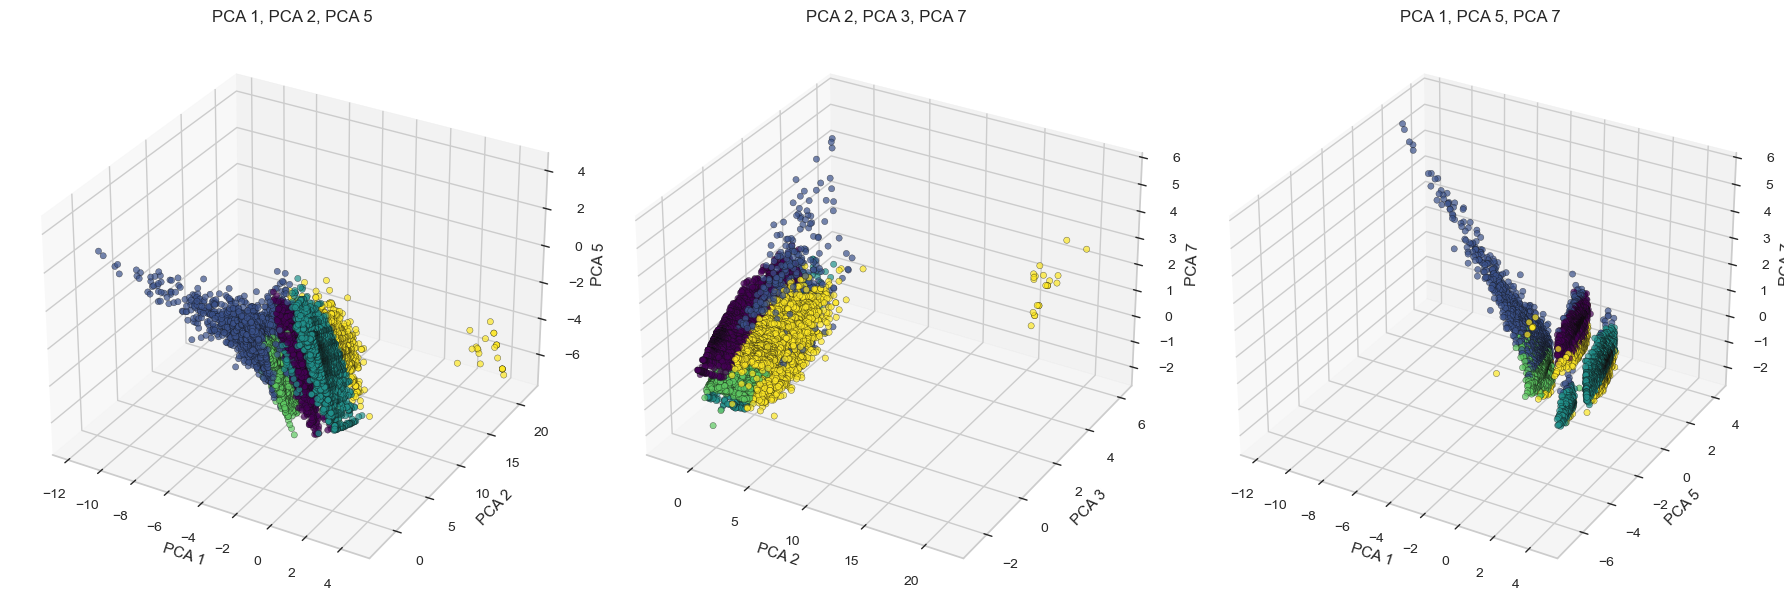

In [202]:
selected_combinations1 = [
    (0, 1, 4),  # PCA 1, PCA 2, PCA 5
    (1, 2, 6),  # PCA 2, PCA 3, PCA 7
    (0, 4, 6)   # PCA 1, PCA 5, PCA 7
]

# Creare una figura con 3 subplot affiancati
fig = plt.figure(figsize=(18, 6))  # Larghezza più grande per accomodare i grafici

for i, (x_idx, y_idx, z_idx) in enumerate(selected_combinations1):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')  # 1 riga, 3 colonne, grafico i+1
    
    # Scatter plot
    ax.scatter(
        X_pca1[:, x_idx], X_pca1[:, y_idx], X_pca1[:, z_idx],
        c=labels_case1, cmap='viridis', alpha=0.7, edgecolor='k'
    )
    
    # Etichette e titolo
    ax.set_title(f'PCA {x_idx+1}, PCA {y_idx+1}, PCA {z_idx+1}')
    ax.set_xlabel(f'PCA {x_idx+1}')
    ax.set_ylabel(f'PCA {y_idx+1}')
    ax.set_zlabel(f'PCA {z_idx+1}')

# Aggiungere spazi tra i grafici per evitare sovrapposizioni
plt.tight_layout()
plt.show()


### ***CLS 2) Let's try it with movies_1b (without genres)***

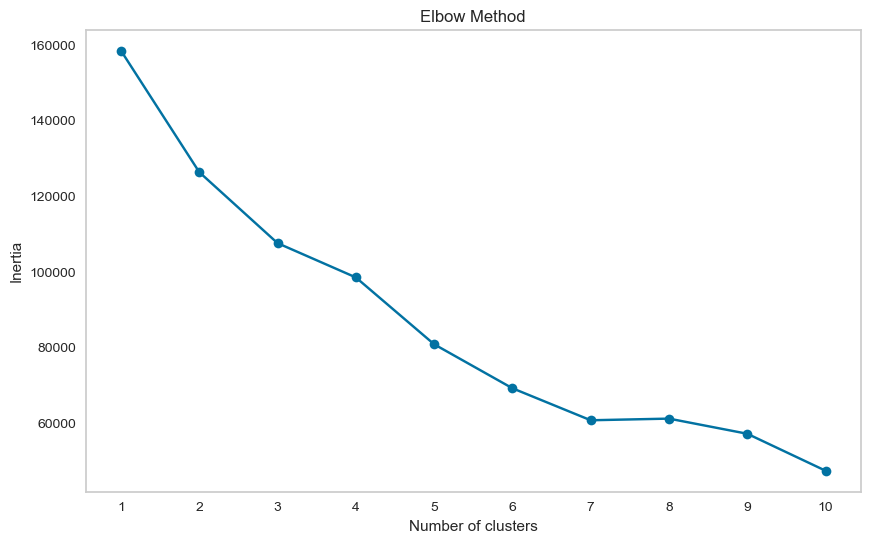

In [159]:
# 1. Elbow Method 
inertia = []
k_values = range(1, 11)

X_pca2 = pca_components2[:, :5]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca2)
    inertia.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

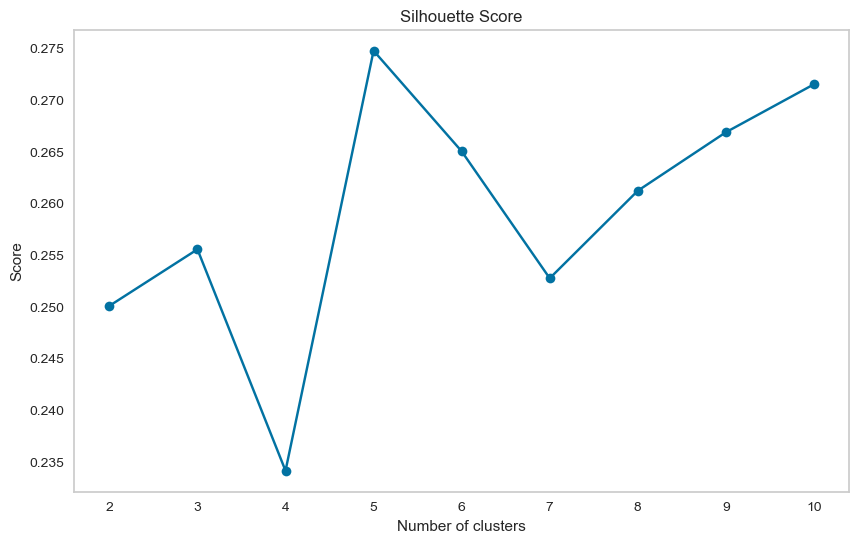

In [160]:
# 2. Silhouette Score

silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels2 = kmeans.fit_predict(X_pca2)
    score2 = silhouette_score(X_pca2, labels2)
    silhouette_scores.append(score2)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='b')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.xticks(k_values)
plt.grid()
plt.show()

In [161]:
def map_phase(data, centroids):
    # Per ogni punto, calcola la distanza da ciascun centroide e assegna un cluster
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    cluster_assignments = np.argmin(distances, axis=1)
    return cluster_assignments


def reduce_phase(data, cluster_assignments, k):
    # Per ogni cluster, calcola la media dei punti assegnati
    new_centroids = np.array([
        data[cluster_assignments == i].mean(axis=0) for i in range(k)
    ])
    return new_centroids


def k_means_mapreduce(data, k, max_iters=100, tol=1e-4):
    # Inizializza i centroidi in modo casuale
    np.random.seed(42)
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    for i in range(max_iters):
        # Fase Map: assegnare ogni punto al cluster più vicino
        cluster_assignments = map_phase(data, centroids)

        # Fase Reduce: calcolare i nuovi centroidi
        new_centroids = reduce_phase(data, cluster_assignments, k)

        # Controllare la convergenza
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, cluster_assignments

In [162]:
# Clustering sul secondo dataset (senza generi)
centroids_case2, labels_case2 = k_means_mapreduce(X_pca2, k=5)

In [163]:
unique2, counts2 = np.unique(labels_case2, return_counts=True)
for cluster_id, count in zip(unique2, counts2):
    print(f"Cluster {cluster_id}: {count} punti")

Cluster 0: 7358 punti
Cluster 1: 4014 punti
Cluster 2: 5492 punti
Cluster 3: 5651 punti
Cluster 4: 4763 punti


In [164]:
cluster_means2 = np.array([X_pca2[labels_case2 == i].mean(axis=0) for i in range(5)])

for i, mean in enumerate(cluster_means2):
    print(f"Cluster {i}: {mean}")

Cluster 0: [ 0.38774004 -0.40266797 -0.73653303  0.14379349  0.49406348]
Cluster 1: [-1.85150713 -0.21736268  1.02744096 -0.04202387  0.25772416]
Cluster 2: [ 1.5057941  -0.65826487  0.73904322  0.31947837 -0.28804154]
Cluster 3: [-1.05662038 -0.16586028 -0.58734596 -0.29617677 -0.73590239]
Cluster 4: [ 0.47871067  1.76103124  0.11663419 -0.20370122  0.22479208]


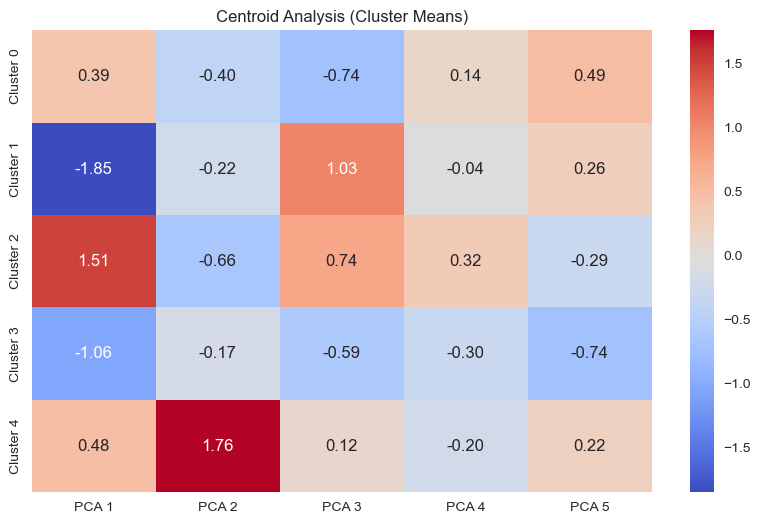

In [165]:
# Creare un DataFrame per i centroidi
centroid_df2 = pd.DataFrame({
    'Cluster 0': [0.38774004, -0.40266797, -0.73653303, 0.14379349, 0.49406348],
    'Cluster 1': [-1.85150713, -0.21736268, 1.02744096, -0.04202387, 0.25772416],
    'Cluster 2': [1.5057941, -0.65826487, 0.73904322, 0.31947837, -0.28804154],
    'Cluster 3': [-1.05662038, -0.16586028, -0.58734596, -0.29617677, -0.73590239],
    'Cluster 4': [0.47871067, 1.76103124, 0.11663419, -0.20370122, 0.22479208]
}).T

centroid_df2.columns = [f"PCA {i+1}" for i in range(centroid_df2.shape[1])]

# Heatmap dei centroidi
plt.figure(figsize=(10, 6))
sns.heatmap(centroid_df2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Centroid Analysis (Cluster Means)")
plt.show()

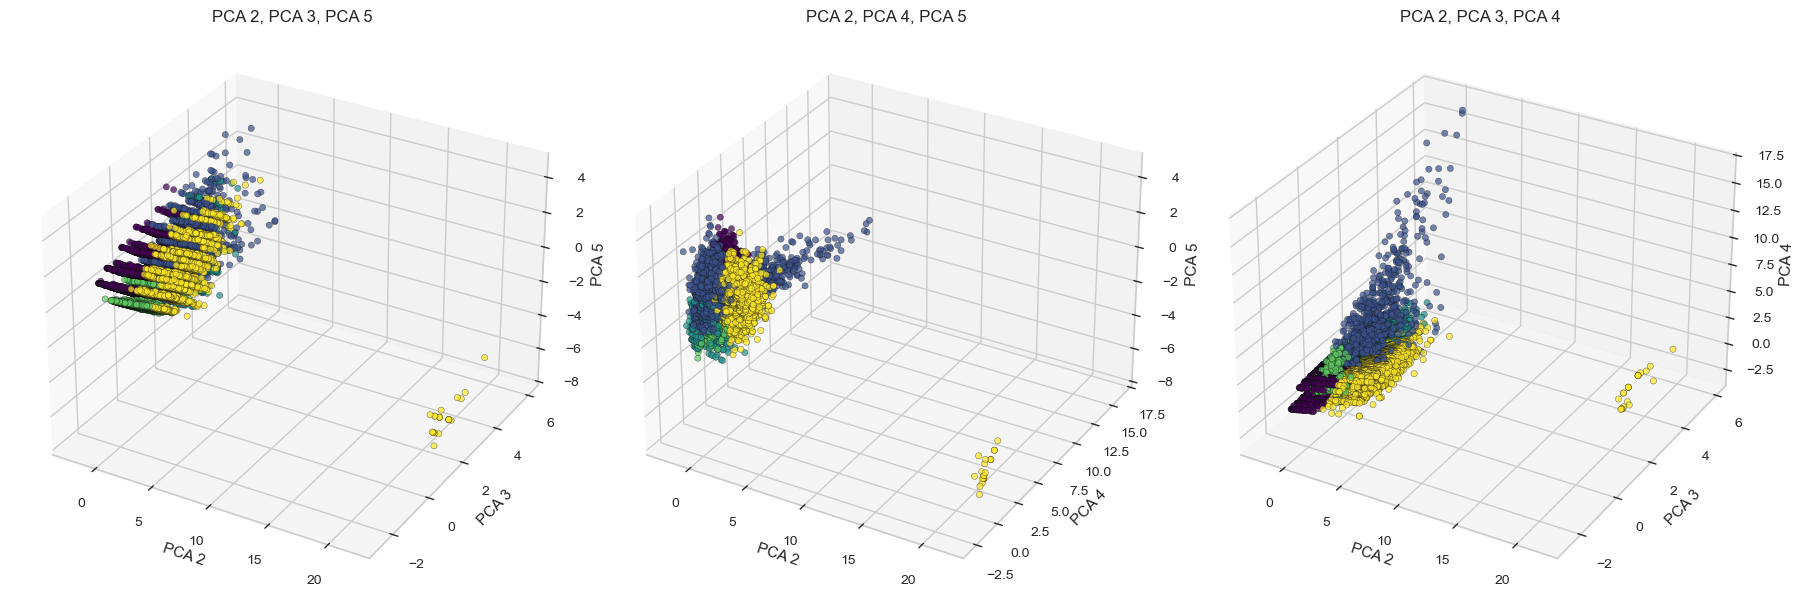

In [235]:
selected_combinations2 = [
    (1, 2, 4),  # PCA 2, PCA 3, PCA 5
    (1, 3, 4),  # PCA 2, PCA 4, PCA 5
    (1, 2, 3)   # PCA 2, PCA 3, PCA 4
]

# Creare una figura con 3 subplot affiancati
fig = plt.figure(figsize=(18, 6))  # Larghezza più grande per accomodare i grafici

for i, (x_idx, y_idx, z_idx) in enumerate(selected_combinations2):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')  # 1 riga, 3 colonne, grafico i+1
    
    # Scatter plot
    ax.scatter(
        X_pca2[:, x_idx], X_pca2[:, y_idx], X_pca2[:, z_idx],
        c=labels_case2, cmap='viridis', alpha=0.7, edgecolor='k'
    )
    
    # Etichette e titolo
    ax.set_title(f'PCA {x_idx+1}, PCA {y_idx+1}, PCA {z_idx+1}')
    ax.set_xlabel(f'PCA {x_idx+1}')
    ax.set_ylabel(f'PCA {y_idx+1}')
    ax.set_zlabel(f'PCA {z_idx+1}')

# Aggiungere spazi tra i grafici per evitare sovrapposizioni
plt.tight_layout()
plt.show()

### ***PCA 3) PCA with all features standardized (also the genres) --> "movies_1c"***

In [166]:
movies_1c = movies_1.drop(['movieId', 'title', 'relevant_genome_tag', 'common_user_tag'], axis=1)

In [171]:
genre_columns = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [174]:
# Standardizzare le colonne dei generi direttamente all'interno di movies_1c
scaler = StandardScaler()
movies_1c[genre_columns] = scaler.fit_transform(movies_1c[genre_columns])



In [240]:
movies_1c

,ratings_avg,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Sci-Fi,Thriller,War,Western,ratings_count,release_year,genre_count,years_since_release,relevant_genome_tag_count,common_user_tag_count
0,1.198467,0,-0.384916,3.272969,5.055775,4.790520,1.502486,-0.347495,-0.315609,-0.978600,...,-0.261265,-0.425283,-0.213951,-0.15941,16.015433,0.118376,2.894060,-0.239887,-1.281111,-0.650275
1,0.119805,0,-0.384916,3.272969,-0.197794,4.790520,-0.665564,-0.347495,-0.315609,-0.978600,...,-0.261265,-0.425283,-0.213951,-0.15941,7.035868,0.118376,0.968217,-0.239887,-1.278789,-0.653467
2,0.027132,0,-0.384916,-0.305533,-0.197794,-0.208746,1.502486,-0.347495,-0.315609,-0.978600,...,-0.261265,-0.425283,-0.213951,-0.15941,3.925795,0.118376,0.005295,-0.239887,-1.279400,-0.657820
3,-0.413369,0,-0.384916,-0.305533,-0.197794,-0.208746,1.502486,-0.347495,-0.315609,1.021868,...,-0.261265,-0.425283,-0.213951,-0.15941,0.661659,0.118376,0.968217,-0.239887,-1.277077,-0.657239
4,-0.104341,0,-0.384916,-0.305533,-0.197794,-0.208746,1.502486,-0.347495,-0.315609,-0.978600,...,-0.261265,-0.425283,-0.213951,-0.15941,3.738040,0.118376,-0.957627,-0.239887,-1.279400,-0.657820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,1.318247,0,-0.384916,-0.305533,-0.197794,-0.208746,1.502486,-0.347495,-0.315609,-0.978600,...,-0.261265,-0.425283,-0.213951,-0.15941,-0.239503,0.314771,-0.957627,-0.753883,0.783809,1.585721
27274,1.318247,0,-0.384916,-0.305533,-0.197794,-0.208746,1.502486,-0.347495,-0.315609,-0.978600,...,-0.261265,-0.425283,-0.213951,-0.15941,-0.239503,0.232940,-0.957627,-0.539718,0.783809,1.585721
27275,-0.962984,0,-0.384916,3.272969,-0.197794,-0.208746,-0.665564,-0.347495,-0.315609,-0.978600,...,-0.261265,-0.425283,-0.213951,-0.15941,-0.239503,0.429335,-0.957627,-1.053714,0.783809,-0.657529
27276,-0.202573,1,-0.384916,-0.305533,-0.197794,-0.208746,-0.665564,-0.347495,-0.315609,-0.978600,...,-0.261265,-0.425283,-0.213951,-0.15941,-0.239503,0.216573,-0.957627,-0.496885,0.783809,1.585721


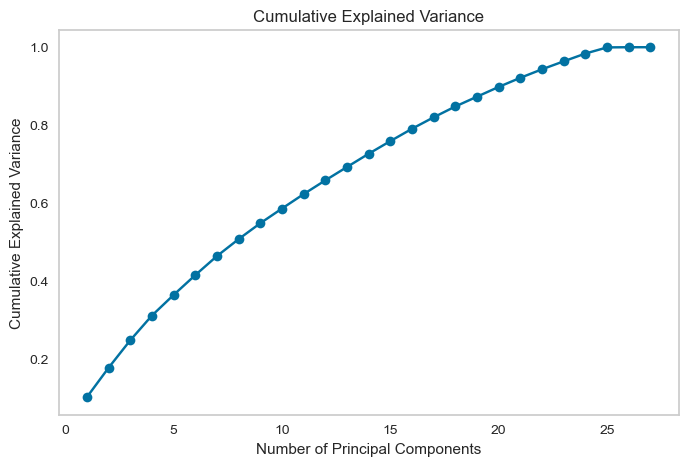

Componente 1: 10.15% varianza spiegata
Componente 2: 7.54% varianza spiegata
Componente 3: 7.06% varianza spiegata
Componente 4: 6.36% varianza spiegata
Componente 5: 5.29% varianza spiegata
Componente 6: 5.09% varianza spiegata
Componente 7: 4.89% varianza spiegata
Componente 8: 4.35% varianza spiegata
Componente 9: 4.08% varianza spiegata
Componente 10: 3.77% varianza spiegata
Componente 11: 3.71% varianza spiegata
Componente 12: 3.54% varianza spiegata
Componente 13: 3.43% varianza spiegata
Componente 14: 3.40% varianza spiegata
Componente 15: 3.24% varianza spiegata
Componente 16: 3.17% varianza spiegata
Componente 17: 2.94% varianza spiegata
Componente 18: 2.78% varianza spiegata
Componente 19: 2.51% varianza spiegata
Componente 20: 2.51% varianza spiegata
Componente 21: 2.34% varianza spiegata
Componente 22: 2.19% varianza spiegata
Componente 23: 2.05% varianza spiegata
Componente 24: 2.00% varianza spiegata
Componente 25: 1.57% varianza spiegata
Componente 26: 0.04% varianza spi

In [177]:
# Applicare la PCA con i generi
pca = PCA()
pca_components3 = pca.fit_transform(movies_1c)

# Visualizzare la varianza spiegata da ciascuna componente principale
explained_variance3 = pca.explained_variance_ratio_

# Scree Plot per analizzare la varianza spiegata
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance3) + 1), explained_variance3.cumsum(), marker='o')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

# Output della varianza spiegata per ciascuna componente
for i, variance in enumerate(explained_variance3, 1):
    print(f"Componente {i}: {variance:.2%} varianza spiegata")

In [185]:
# Scegliere il numero di componenti principali (ad esempio, quelle che spiegano il 90% della varianza)
cumulative_variance3 = np.cumsum(explained_variance3)
n_components = np.argmax(cumulative_variance3 >= 0.80) + 1  # Numero minimo di componenti per spiegare l'80%
print(f"Numero di componenti principali necessarie per spiegare l'80% della varianza: {n_components}")
n_components = np.argmax(cumulative_variance3 >= 0.35) + 1  # Numero minimo di componenti per spiegare il 35%
print(f"Numero di componenti principali necessarie per spiegare il 40% della varianza: {n_components}")

Numero di componenti principali necessarie per spiegare l'80% della varianza: 17
Numero di componenti principali necessarie per spiegare il 40% della varianza: 5


### ***CLS 3) Clustering with all the features standardized (also the genres) --> "movies_1c"***

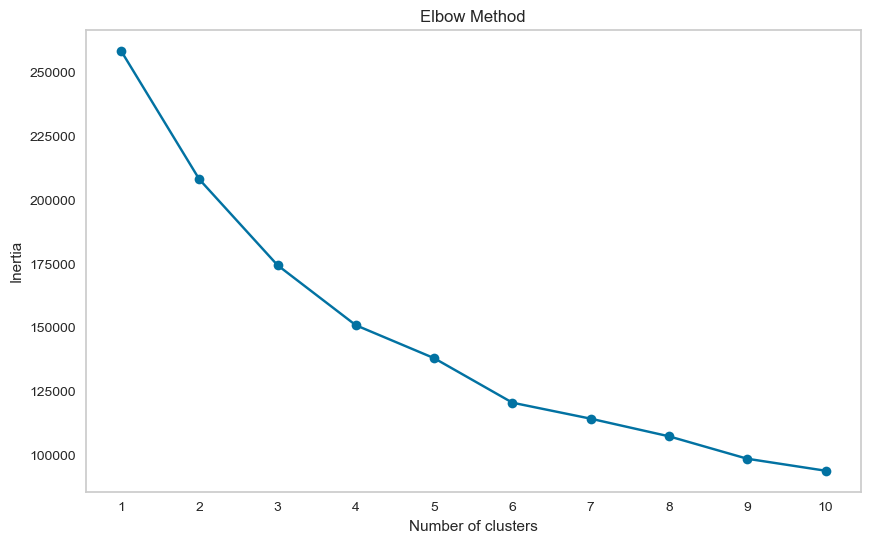

In [186]:
# 1. Elbow Method 
inertia = []
k_values = range(1, 11)

X_pca3 = pca_components3[:, :5]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca3)
    inertia.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

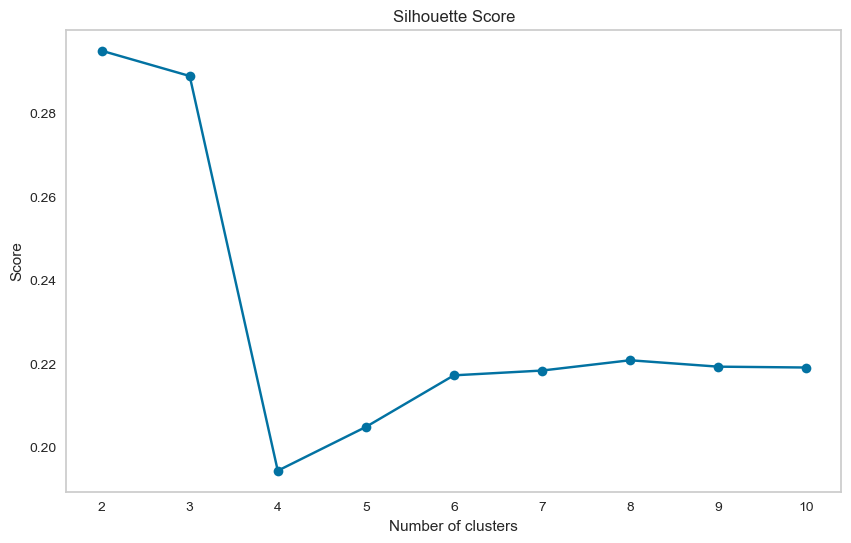

In [187]:
# 2. Silhouette Score

silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels3 = kmeans.fit_predict(X_pca3)
    score3 = silhouette_score(X_pca3, labels3)
    silhouette_scores.append(score3)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='b')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.xticks(k_values)
plt.grid()
plt.show()

In [188]:
def map_phase(data, centroids):
    # Per ogni punto, calcola la distanza da ciascun centroide e assegna un cluster
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    cluster_assignments = np.argmin(distances, axis=1)
    return cluster_assignments


def reduce_phase(data, cluster_assignments, k):
    # Per ogni cluster, calcola la media dei punti assegnati
    new_centroids = np.array([
        data[cluster_assignments == i].mean(axis=0) for i in range(k)
    ])
    return new_centroids


def k_means_mapreduce(data, k, max_iters=100, tol=1e-4):
    # Inizializza i centroidi in modo casuale
    np.random.seed(42)
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    for i in range(max_iters):
        # Fase Map: assegnare ogni punto al cluster più vicino
        cluster_assignments = map_phase(data, centroids)

        # Fase Reduce: calcolare i nuovi centroidi
        new_centroids = reduce_phase(data, cluster_assignments, k)

        # Controllare la convergenza
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, cluster_assignments

In [193]:
# Clustering sul secondo dataset (senza generi)
centroids_case3, labels_case3 = k_means_mapreduce(X_pca3, k=3)

In [194]:
unique3, counts3 = np.unique(labels_case3, return_counts=True)
for cluster_id, count in zip(unique3, counts3):
    print(f"Cluster {cluster_id}: {count} punti")

Cluster 0: 5202 punti
Cluster 1: 2690 punti
Cluster 2: 19386 punti


In [195]:
cluster_means3 = np.array([X_pca3[labels_case3 == i].mean(axis=0) for i in range(3)])

for i, mean in enumerate(cluster_means3):
    print(f"Cluster {i}: {mean}")

Cluster 0: [ 1.42891513  1.88502273 -0.67480632 -0.05121242  0.25706725]
Cluster 1: [ 2.98942747 -2.10491877 -0.15973065  0.32025768 -0.79408684]
Cluster 2: [-0.79824494 -0.2137448   0.20324037 -0.03069669  0.04120653]


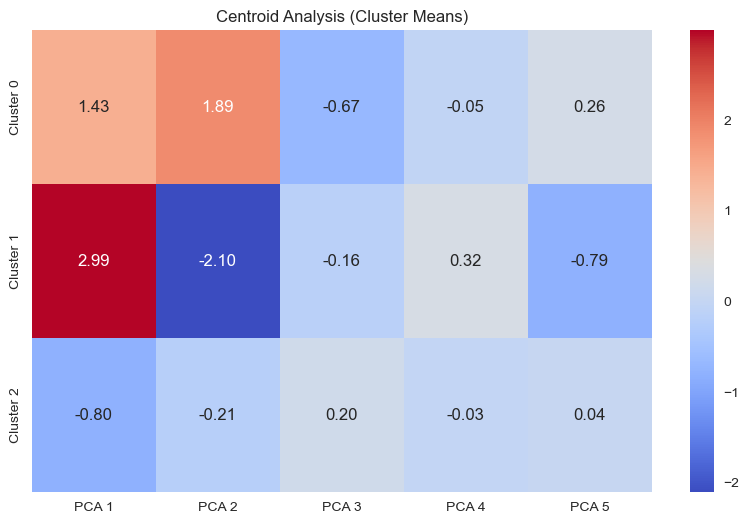

In [197]:
# Creare un DataFrame per i centroidi
centroid_df3 = pd.DataFrame({
    'Cluster 0': [ 1.42891513, 1.88502273, -0.67480632, -0.05121242, 0.25706725],
    'Cluster 1': [ 2.98942747, -2.10491877, -0.15973065, 0.32025768, -0.79408684],
    'Cluster 2': [-0.79824494, -0.2137448, 0.20324037, -0.03069669, 0.04120653],
}).T

centroid_df3.columns = [f"PCA {i+1}" for i in range(centroid_df3.shape[1])]

# Heatmap dei centroidi
plt.figure(figsize=(10, 6))
sns.heatmap(centroid_df3, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Centroid Analysis (Cluster Means)")
plt.show()

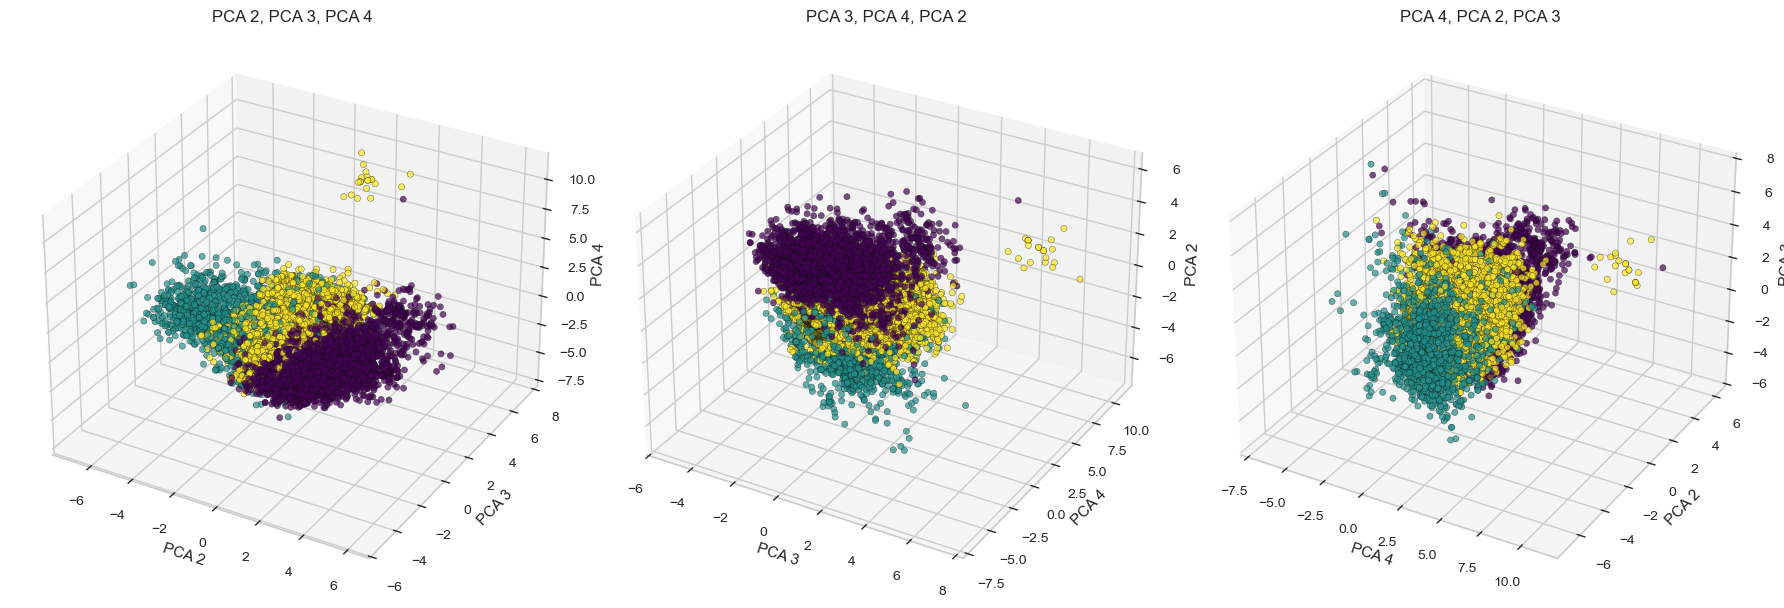

In [234]:
selected_combinations3 = [
    (1, 2, 3),  # PCA 2, PCA 3, PCA 4
    (2, 3, 1),  # PCA 2, PCA 3, PCA 5
    (3, 1, 2)   # PCA 2, PCA 4, PCA 5
]

# Creare una figura con 3 subplot affiancati
fig = plt.figure(figsize=(18, 6))  # Larghezza più grande per accomodare i grafici

for i, (x_idx, y_idx, z_idx) in enumerate(selected_combinations3):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')  # 1 riga, 3 colonne, grafico i+1
    
    # Scatter plot
    ax.scatter(
        X_pca3[:, x_idx], X_pca3[:, y_idx], X_pca3[:, z_idx],
        c=labels_case3, cmap='viridis', alpha=0.7, edgecolor='k'
    )
    
    # Etichette e titolo
    ax.set_title(f'PCA {x_idx+1}, PCA {y_idx+1}, PCA {z_idx+1}')
    ax.set_xlabel(f'PCA {x_idx+1}')
    ax.set_ylabel(f'PCA {y_idx+1}')
    ax.set_zlabel(f'PCA {z_idx+1}')

# Aggiungere spazi tra i grafici per evitare sovrapposizioni
plt.tight_layout()
plt.show()

# ***B) TEST: Trying PCA and then the Clustering without Tag Counts Features ("relevant_genome_tag_count" and "common_user_tag_count")***

In [210]:
movies_1d = movies_1c.copy()

In [212]:
movies_1d = movies_1d.drop(['relevant_genome_tag_count', 'common_user_tag_count'], axis=1)

In [213]:
movies_1d

,ratings_avg,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_count,release_year,genre_count,years_since_release
0,1.198467,0,-0.384916,3.272969,5.055775,4.790520,1.502486,-0.347495,-0.315609,-0.978600,...,-0.242413,-0.422214,-0.261265,-0.425283,-0.213951,-0.15941,16.015433,0.118376,2.894060,-0.239887
1,0.119805,0,-0.384916,3.272969,-0.197794,4.790520,-0.665564,-0.347495,-0.315609,-0.978600,...,-0.242413,-0.422214,-0.261265,-0.425283,-0.213951,-0.15941,7.035868,0.118376,0.968217,-0.239887
2,0.027132,0,-0.384916,-0.305533,-0.197794,-0.208746,1.502486,-0.347495,-0.315609,-0.978600,...,-0.242413,2.368469,-0.261265,-0.425283,-0.213951,-0.15941,3.925795,0.118376,0.005295,-0.239887
3,-0.413369,0,-0.384916,-0.305533,-0.197794,-0.208746,1.502486,-0.347495,-0.315609,1.021868,...,-0.242413,2.368469,-0.261265,-0.425283,-0.213951,-0.15941,0.661659,0.118376,0.968217,-0.239887
4,-0.104341,0,-0.384916,-0.305533,-0.197794,-0.208746,1.502486,-0.347495,-0.315609,-0.978600,...,-0.242413,-0.422214,-0.261265,-0.425283,-0.213951,-0.15941,3.738040,0.118376,-0.957627,-0.239887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,1.318247,0,-0.384916,-0.305533,-0.197794,-0.208746,1.502486,-0.347495,-0.315609,-0.978600,...,-0.242413,-0.422214,-0.261265,-0.425283,-0.213951,-0.15941,-0.239503,0.314771,-0.957627,-0.753883
27274,1.318247,0,-0.384916,-0.305533,-0.197794,-0.208746,1.502486,-0.347495,-0.315609,-0.978600,...,-0.242413,-0.422214,-0.261265,-0.425283,-0.213951,-0.15941,-0.239503,0.232940,-0.957627,-0.539718
27275,-0.962984,0,-0.384916,3.272969,-0.197794,-0.208746,-0.665564,-0.347495,-0.315609,-0.978600,...,-0.242413,-0.422214,-0.261265,-0.425283,-0.213951,-0.15941,-0.239503,0.429335,-0.957627,-1.053714
27276,-0.202573,1,-0.384916,-0.305533,-0.197794,-0.208746,-0.665564,-0.347495,-0.315609,-0.978600,...,-0.242413,-0.422214,-0.261265,-0.425283,-0.213951,-0.15941,-0.239503,0.216573,-0.957627,-0.496885


### ***PCA 4) with "movies_1d" (without Tag Counts Features)*** 

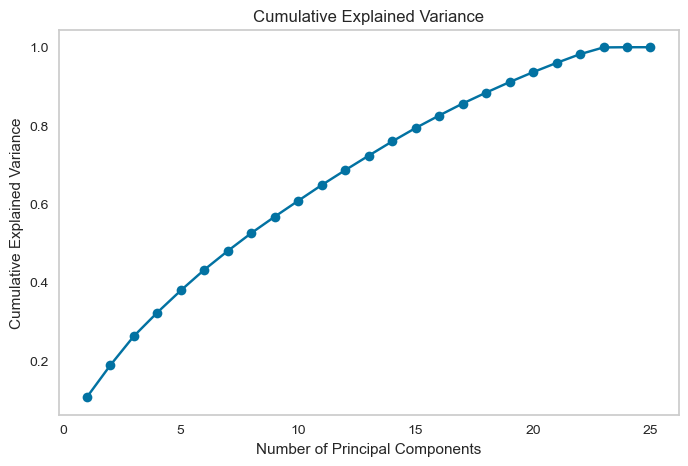

Componente 1: 10.60% varianza spiegata
Componente 2: 8.17% varianza spiegata
Componente 3: 7.43% varianza spiegata
Componente 4: 6.04% varianza spiegata
Componente 5: 5.63% varianza spiegata
Componente 6: 5.29% varianza spiegata
Componente 7: 4.81% varianza spiegata
Componente 8: 4.55% varianza spiegata
Componente 9: 4.20% varianza spiegata
Componente 10: 4.06% varianza spiegata
Componente 11: 4.01% varianza spiegata
Componente 12: 3.80% varianza spiegata
Componente 13: 3.70% varianza spiegata
Componente 14: 3.63% varianza spiegata
Componente 15: 3.44% varianza spiegata
Componente 16: 3.19% varianza spiegata
Componente 17: 3.05% varianza spiegata
Componente 18: 2.80% varianza spiegata
Componente 19: 2.68% varianza spiegata
Componente 20: 2.54% varianza spiegata
Componente 21: 2.37% varianza spiegata
Componente 22: 2.23% varianza spiegata
Componente 23: 1.73% varianza spiegata
Componente 24: 0.05% varianza spiegata
Componente 25: 0.00% varianza spiegata


In [214]:
# Applicare la PCA con i generi
pca = PCA()
pca_components4 = pca.fit_transform(movies_1d)

# Visualizzare la varianza spiegata da ciascuna componente principale
explained_variance4 = pca.explained_variance_ratio_

# Scree Plot per analizzare la varianza spiegata
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance4) + 1), explained_variance4.cumsum(), marker='o')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

# Output della varianza spiegata per ciascuna componente
for i, variance in enumerate(explained_variance4, 1):
    print(f"Componente {i}: {variance:.2%} varianza spiegata")

In [215]:
# Scegliere il numero di componenti principali (ad esempio, quelle che spiegano il 90% della varianza)
cumulative_variance4 = np.cumsum(explained_variance4)
n_components = np.argmax(cumulative_variance4 >= 0.80) + 1  # Numero minimo di componenti per spiegare l'80%
print(f"Numero di componenti principali necessarie per spiegare l'80% della varianza: {n_components}")
n_components = np.argmax(cumulative_variance4 >= 0.35) + 1  # Numero minimo di componenti per spiegare il 35%
print(f"Numero di componenti principali necessarie per spiegare il 40% della varianza: {n_components}")

Numero di componenti principali necessarie per spiegare l'80% della varianza: 16
Numero di componenti principali necessarie per spiegare il 40% della varianza: 5


### ***CLS 4) Clustering with no Tag Counts Features***

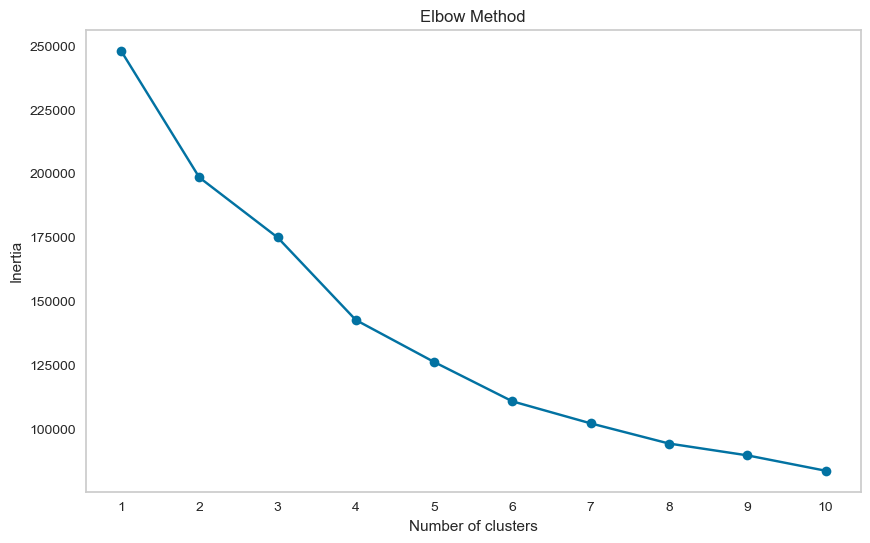

In [217]:
# 1. Elbow Method 
inertia = []
k_values = range(1, 11)

X_pca4 = pca_components4[:, :5]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca4)
    inertia.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

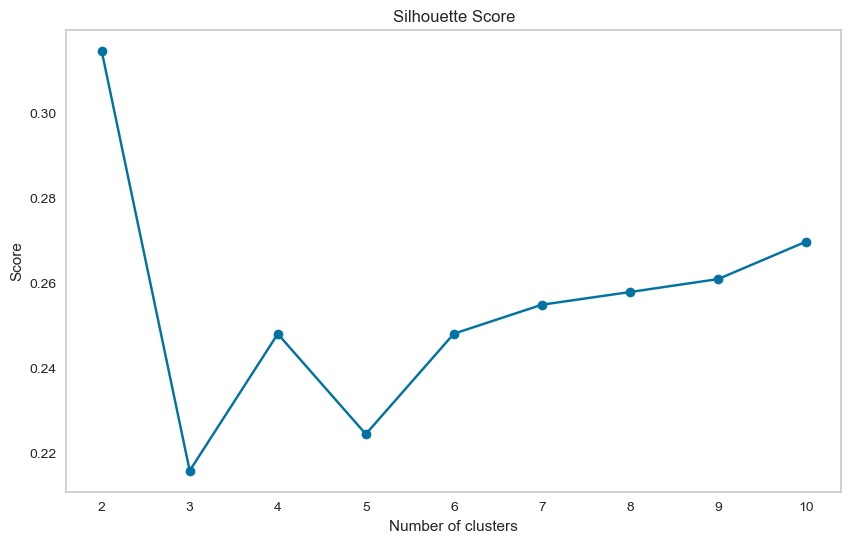

In [219]:
# 2. Silhouette Score

silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels4 = kmeans.fit_predict(X_pca4)
    score4 = silhouette_score(X_pca4, labels4)
    silhouette_scores.append(score4)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='b')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.xticks(k_values)
plt.grid()
plt.show()

In [222]:
# Clustering sul secondo dataset (senza generi)
centroids_case4, labels_case4 = k_means_mapreduce(X_pca4, k=2)

In [223]:
unique4, counts4 = np.unique(labels_case4, return_counts=True)
for cluster_id, count in zip(unique4, counts4):
    print(f"Cluster {cluster_id}: {count} punti")

Cluster 0: 19900 punti
Cluster 1: 7378 punti


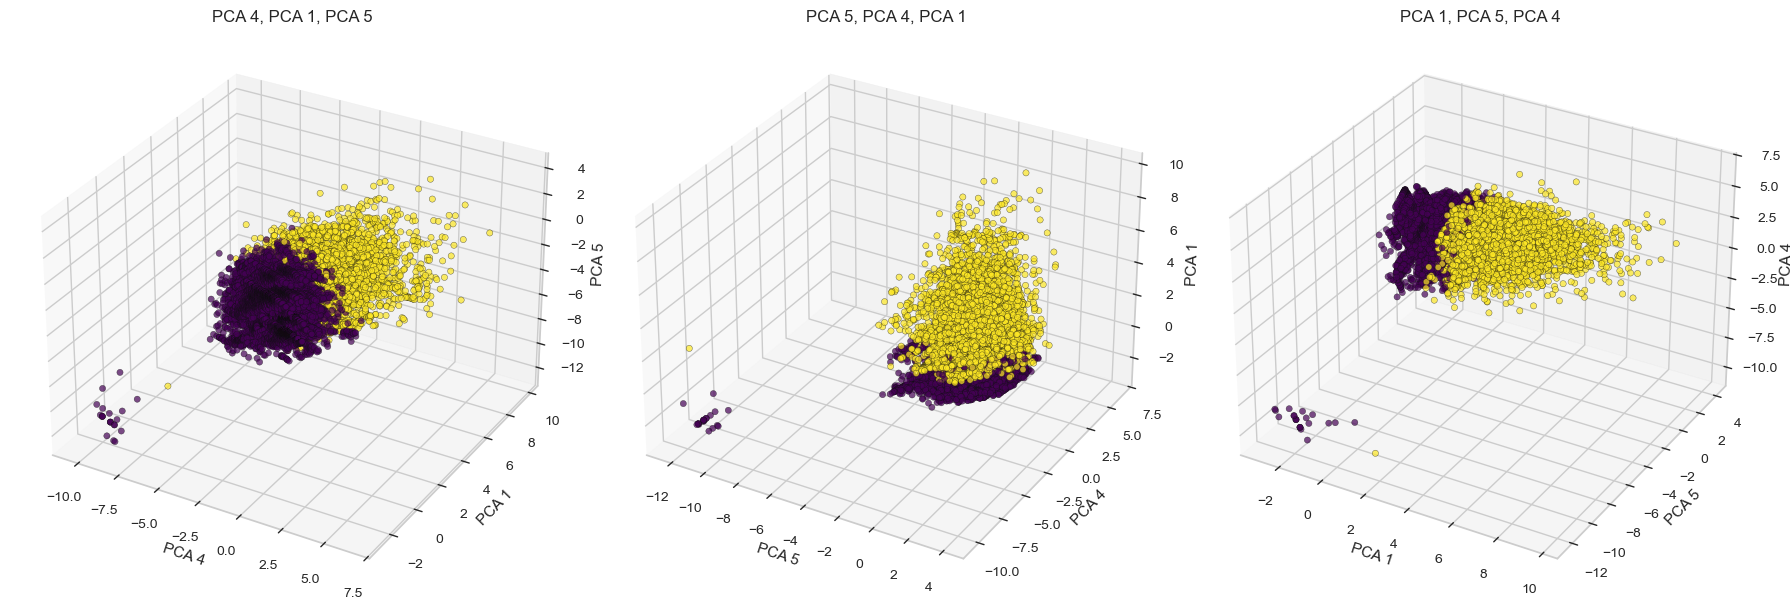

In [238]:
selected_combinations4 = [
    (3, 0, 4),  # PCA 2, PCA 3, PCA 1
    (4, 3, 0),  # PCA 2, PCA 3, PCA 5
    (0, 4, 3)   # PCA 2, PCA 4, PCA 5
]

# Creare una figura con 3 subplot affiancati
fig = plt.figure(figsize=(18, 6))  # Larghezza più grande per accomodare i grafici

for i, (x_idx, y_idx, z_idx) in enumerate(selected_combinations4):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')  # 1 riga, 3 colonne, grafico i+1
    
    # Scatter plot
    ax.scatter(
        X_pca4[:, x_idx], X_pca4[:, y_idx], X_pca4[:, z_idx],
        c=labels_case4, cmap='viridis', alpha=0.7, edgecolor='k'
    )
    
    # Etichette e titolo
    ax.set_title(f'PCA {x_idx+1}, PCA {y_idx+1}, PCA {z_idx+1}')
    ax.set_xlabel(f'PCA {x_idx+1}')
    ax.set_ylabel(f'PCA {y_idx+1}')
    ax.set_zlabel(f'PCA {z_idx+1}')

# Aggiungere spazi tra i grafici per evitare sovrapposizioni
plt.tight_layout()
plt.show()

**Lastly, let's see the frequency of all the genres:**

In [66]:
# frequenza di ogni genere
genre_freq = genre_data.sum().sort_values(ascending=False)
print(genre_freq)

Drama          13344
Comedy          8374
Thriller        4178
Romance         4127
Action          3520
Crime           2939
Horror          2611
Documentary     2471
Adventure       2329
Sci-Fi          1743
Mystery         1514
Fantasy         1412
War             1194
Children        1139
Musical         1036
Animation       1027
Western          676
Film-Noir        330
IMAX             196
dtype: int64


In [239]:
# creo file csv da movies_1a, movies_1b, movies_1c, movies_1d
movies_1a.to_csv('/Users/lucaderuggiero/Desktop/dataset ADM3/movies_1a.csv', index=False)
movies_1b.to_csv('/Users/lucaderuggiero/Desktop/dataset ADM3/movies_1b.csv', index=False)
movies_1c.to_csv('/Users/lucaderuggiero/Desktop/dataset ADM3/movies_1c.csv', index=False)
movies_1d.to_csv('/Users/lucaderuggiero/Desktop/dataset ADM3/movies_1d.csv', index=False)